<a href="https://colab.research.google.com/github/ocjorge/CarDetection/blob/main/CarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================================
# PASO -1: MONTAR GOOGLE DRIVE
# ==============================================================================
print("Paso -1: Montando Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

Paso -1: Montando Google Drive...
Mounted at /content/drive


In [2]:
# ==============================================================================
# PASO 0: INSTALACIÓN DE LIBRERÍAS NECESARIAS
# ==============================================================================
print("\nPaso 0: Instalando librerías...")
!pip install ultralytics -q
!pip install pyyaml -q

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import zipfile
from ultralytics import YOLO
import ultralytics
from google.colab import files

print("Librerías instaladas y módulos importados.")
print(f"Ultralytics versión: {ultralytics.__version__}")


Paso 0: Instalando librerías...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo setting

In [3]:
# ==============================================================================
# PASO 0.5: CONFIGURACIÓN DE RUTAS DE DRIVE Y DESCOMPRESIÓN DEL DATASET (TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 0.5: Configurando rutas de Drive y descomprimiendo TU dataset de vehículos...")

# --------- MODIFICA ESTAS VARIABLES SI ES NECESARIO ---------
# Ruta en tu Google Drive donde está el archivo ZIP de tu dataset DE VEHÍCULOS
DRIVE_DATASET_ZIP_PATH = "/content/vehicle_dataset.zip"  # <<<<<<< CAMBIA ESTO a la ruta de tu ZIP de VEHÍCULOS

COLAB_BASE_PATH = "/content/"
EXTRACT_DIR_NAME = "vehicle_dataset_extracted"
EXTRACT_TO_DIR = os.path.join(COLAB_BASE_PATH, EXTRACT_DIR_NAME)

# Nombre de la carpeta principal DENTRO del ZIP que contiene 'train', 'valid', etc.
EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP = "vehicle dataset" # <<<<<<< AJUSTA ESTO según la estructura de tu ZIP de VEHÍCULOS
# -----------------------------------------------------------

DRIVE_WORKING_DIR_BASE = "/content/drive/MyDrive/YOLO_FineTuning_Results"
os.makedirs(DRIVE_WORKING_DIR_BASE, exist_ok=True)
COLAB_WORKING_DIR = os.path.join(COLAB_BASE_PATH, "yolo_finetune_output")

if os.path.exists(DRIVE_DATASET_ZIP_PATH):
    print(f"Archivo ZIP encontrado en Drive: {DRIVE_DATASET_ZIP_PATH}")
    print(f"Extrayendo a: {EXTRACT_TO_DIR}...")
    os.makedirs(EXTRACT_TO_DIR, exist_ok=True)
    !unzip -q -o "{DRIVE_DATASET_ZIP_PATH}" -d "{EXTRACT_TO_DIR}"
    print("Descompresión completada.")

    if EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP:
        BASE_DATASET_PATH = os.path.join(EXTRACT_TO_DIR, EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP)
    else:
        BASE_DATASET_PATH = EXTRACT_TO_DIR

    print(f"El dataset base (vehículos) ahora está en: {BASE_DATASET_PATH}")
    if not os.path.exists(BASE_DATASET_PATH):
        raise FileNotFoundError(f"Dataset de vehículos no encontrado en {BASE_DATASET_PATH} después de la extracción.")
else:
    raise FileNotFoundError(f"Archivo ZIP de vehículos {DRIVE_DATASET_ZIP_PATH} no encontrado en Google Drive.")



Paso 0.5: Configurando rutas de Drive y descomprimiendo TU dataset de vehículos...
Archivo ZIP encontrado en Drive: /content/vehicle_dataset.zip
Extrayendo a: /content/vehicle_dataset_extracted...
Descompresión completada.
El dataset base (vehículos) ahora está en: /content/vehicle_dataset_extracted/vehicle dataset


In [4]:
# ==============================================================================
# PASO 1: DEFINICIÓN DE RUTAS Y VARIABLES PRINCIPALES (PARA EL DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 1: Definiendo rutas y variables...")

TRAIN_DIR = os.path.join(BASE_DATASET_PATH, 'train')
VALID_DIR = os.path.join(BASE_DATASET_PATH, 'valid')

# ----- CLASES EN TU DATASET DE VEHÍCULOS (para el data.yaml y entrenamiento) -----
# Estas son las clases que tu dataset de vehículos contiene y que el modelo aprenderá/refinará.
CLASSES_IN_VEHICLE_DATASET = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van'] # <<<< AJUSTA ESTO EXACTAMENTE a tu dataset
NUM_CLASSES_VEHICLE_DATASET = len(CLASSES_IN_VEHICLE_DATASET)
# ------------------------------------------------------------------------------------

# ----- CLASES QUE ESPERAMOS DETECTAR EN INFERENCIA (incluye las de COCO) -----
# El modelo base yolov8n.pt conoce las clases de COCO.
# Después del fine-tuning, el modelo debería reconocer tus vehículos Y las clases de COCO.
# "pothole" NO está en COCO. Si quieres "pothole", NECESITAS añadir datos para ello.
CLASSES_FOR_INFERENCE = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'dog', # Comunes de COCO
                         'threewheel', 'van'] # Específicas de tu dataset
# NOTA: 'pothole' se omite aquí porque no tenemos datos para ello.
# Si TUVIERAS un dataset de potholes y lo incluyeras en el entrenamiento, lo añadirías aquí.
# ------------------------------------------------------------------------------------


os.makedirs(COLAB_WORKING_DIR, exist_ok=True)
DATA_YAML_PATH = os.path.join(COLAB_WORKING_DIR, 'vehicle_data.yaml') # YAML para tu dataset de vehículos

print(f"Directorio de entrenamiento (vehículos): {TRAIN_DIR}")
print(f"Directorio de validación (vehículos): {VALID_DIR}")
print(f"Clases en TU dataset de vehículos (para entrenamiento): {CLASSES_IN_VEHICLE_DATASET}")
print(f"Clases esperadas en inferencia (aprox): {CLASSES_FOR_INFERENCE}")
print(f"Archivo YAML se guardará en: {DATA_YAML_PATH}")
print(f"Los resultados del entrenamiento (runs) se guardarán temporalmente en: {COLAB_WORKING_DIR}/runs")

# Verificaciones de directorios
for d_path in [TRAIN_DIR, VALID_DIR]:
    if not os.path.exists(d_path) or \
       not os.path.exists(os.path.join(d_path, 'images')) or \
       not os.path.exists(os.path.join(d_path, 'labels')):
        print(f"ADVERTENCIA: El directorio {d_path} o sus subcarpetas 'images'/'labels' no existen o están mal configurados.")


Paso 1: Definiendo rutas y variables...
Directorio de entrenamiento (vehículos): /content/vehicle_dataset_extracted/vehicle dataset/train
Directorio de validación (vehículos): /content/vehicle_dataset_extracted/vehicle dataset/valid
Clases en TU dataset de vehículos (para entrenamiento): ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']
Clases esperadas en inferencia (aprox): ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'dog', 'threewheel', 'van']
Archivo YAML se guardará en: /content/yolo_finetune_output/vehicle_data.yaml
Los resultados del entrenamiento (runs) se guardarán temporalmente en: /content/yolo_finetune_output/runs



Paso 2: Exploración de datos (dataset de vehículos)...


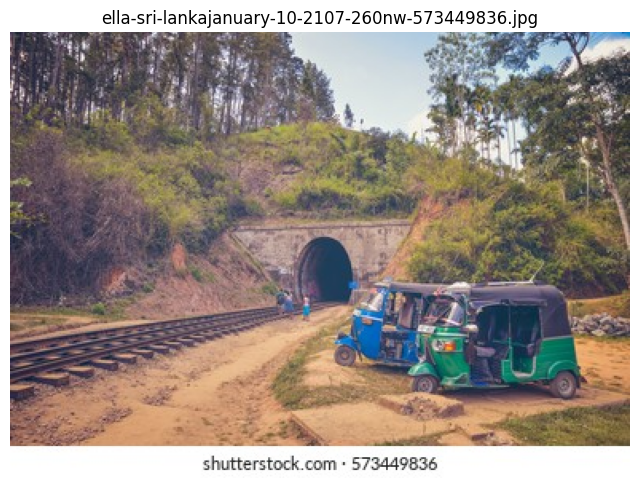


Contando etiquetas en el conjunto de entrenamiento de VEHÍCULOS (/content/vehicle_dataset_extracted/vehicle dataset/train/labels)...

Distribución de clases en el conjunto de entrenamiento (VEHÍCULOS):
car: 461
threewheel: 482
bus: 403
truck: 478
motorbike: 483
van: 378


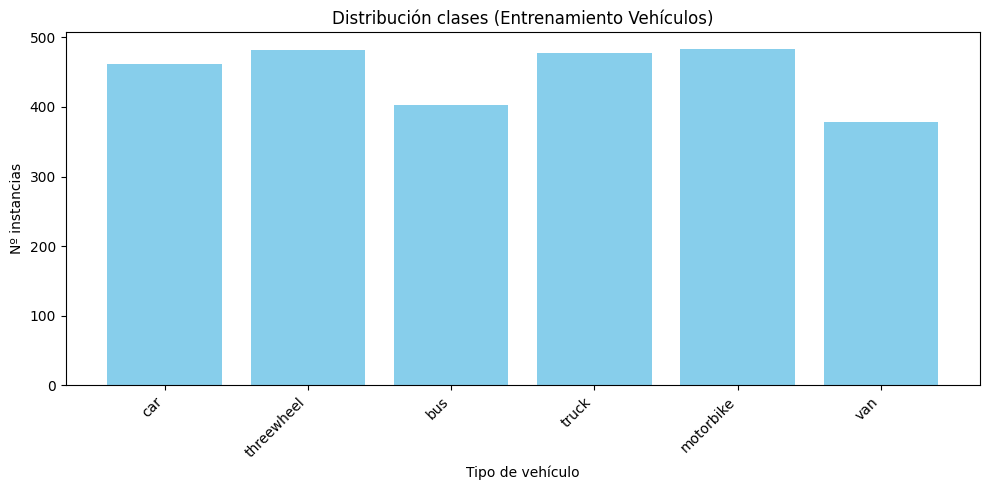

In [5]:
# ==============================================================================
# PASO 2: EXPLORACIÓN DE DATOS (DE TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 2: Exploración de datos (dataset de vehículos)...")
def image_plot(file_path): # Misma función
    img = cv2.imread(file_path);
    if img is None: print(f"Error: No se pudo cargar la imagen {file_path}"); return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); plt.figure(figsize=(8,8))
    plt.imshow(img_rgb); plt.title(os.path.basename(file_path)); plt.axis('off'); plt.show()
    return img_rgb

train_images_path = os.path.join(TRAIN_DIR, 'images')
try:
    sample_images_list = glob.glob(os.path.join(train_images_path, '*.jpg')) + glob.glob(os.path.join(train_images_path, '*.png'))
    if sample_images_list: image_plot(sample_images_list[0])
    else: print(f"No se encontraron imágenes en {train_images_path}")
except Exception as e: print(f"Error listando imágenes: {e}")

def count_labels_in_files(label_files_dir, num_classes, class_names_map): # Misma función
    counts = {name: 0 for name in class_names_map}
    if not os.path.exists(label_files_dir): print(f"Dir de etiquetas no encontrado: {label_files_dir}"); return counts
    label_files = glob.glob(os.path.join(label_files_dir, '*.txt'))
    if not label_files: print(f"No archivos .txt en {label_files_dir}"); return counts
    for file_path in label_files:
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.split();
                    if parts:
                        class_id = int(parts[0])
                        if 0 <= class_id < num_classes: counts[class_names_map[class_id]] += 1
                        else: print(f"ID clase fuera de rango ({class_id}) en: {file_path}")
        except Exception as e: print(f"Error procesando {file_path}: {e}")
    return counts

train_labels_dir = os.path.join(TRAIN_DIR, 'labels')
print(f"\nContando etiquetas en el conjunto de entrenamiento de VEHÍCULOS ({train_labels_dir})...")
label_counts_dict = count_labels_in_files(train_labels_dir, NUM_CLASSES_VEHICLE_DATASET, CLASSES_IN_VEHICLE_DATASET)

print("\nDistribución de clases en el conjunto de entrenamiento (VEHÍCULOS):")
for class_name, count in label_counts_dict.items(): print(f"{class_name}: {count}")
if sum(label_counts_dict.values()) > 0 :
    plt.figure(figsize=(10, 5)); plt.bar(label_counts_dict.keys(), label_counts_dict.values(), color='skyblue')
    plt.xlabel('Tipo de vehículo'); plt.ylabel('Nº instancias'); plt.title('Distribución clases (Entrenamiento Vehículos)')
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
else: print("No se encontraron etiquetas para graficar.")

In [6]:
# ==============================================================================
# PASO 3: CREACIÓN DEL ARCHIVO data.yaml (PARA TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 3: Creando el archivo data.yaml para el dataset de vehículos...")
data_yaml_content = {
    'path': BASE_DATASET_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'nc': NUM_CLASSES_VEHICLE_DATASET,
    'names': CLASSES_IN_VEHICLE_DATASET # Solo las clases de tu dataset de vehículos
}
try:
    with open(DATA_YAML_PATH, 'w') as f: yaml.dump(data_yaml_content, f, sort_keys=False, Dumper=yaml.SafeDumper)
    print(f"Archivo data.yaml creado en {DATA_YAML_PATH}")
    with open(DATA_YAML_PATH, 'r') as f: print(f"\nContenido de data.yaml:\n{f.read()}")
except Exception as e: print(f"Error al crear data.yaml: {e}")



Paso 3: Creando el archivo data.yaml para el dataset de vehículos...
Archivo data.yaml creado en /content/yolo_finetune_output/vehicle_data.yaml

Contenido de data.yaml:
path: /content/vehicle_dataset_extracted/vehicle dataset
train: train/images
val: valid/images
nc: 6
names:
- car
- threewheel
- bus
- truck
- motorbike
- van



In [ ]:
# ==============================================================================
# PASO 4: FINE-TUNING DEL MODELO YOLOv8 CON TU DATASET DE VEHÍCULOS
# ==============================================================================
print("\nPaso 4: Fine-tuning del modelo YOLOv8n.pt con tu dataset de vehículos...")
print("\nRealizando chequeo de Ultralytics..."); ultralytics.checks()

model = YOLO("yolov8n.pt") # Empezamos con el modelo pre-entrenado en COCO
print(f"\nModelo YOLO('yolov8n.pt') cargado. Este modelo ya conoce clases de COCO como 'person', 'dog', 'bicycle', 'car'.")
print("Ahora haremos fine-tuning con tu dataset para mejorar/añadir tus clases de vehículos.")

BATCH_SIZE = 16
EPOCHS = 30 # Para fine-tuning, a veces menos épocas son suficientes, pero monitorea. Ajusta según sea necesario.
IMG_SIZE = 640
PROJECT_NAME_TRAIN = "finetune_vehicles"
EXPERIMENT_NAME_TRAIN = "exp_vehicles_on_coco_base"

print(f"Iniciando fine-tuning con batch_size={BATCH_SIZE}, epochs={EPOCHS}, imgsz={IMG_SIZE}")
print(f"Usando data YAML: {DATA_YAML_PATH} (con tus clases de vehículos)")
print(f"Los resultados se guardarán en: {COLAB_WORKING_DIR}/runs/{PROJECT_NAME_TRAIN}/{EXPERIMENT_NAME_TRAIN}")

if not os.path.exists(DATA_YAML_PATH):
    print(f"ERROR CRÍTICO: El archivo {DATA_YAML_PATH} no existe. No se puede entrenar.")
else:
    try:
        results = model.train(
            data=DATA_YAML_PATH, # YAML específico de tu dataset de vehículos
            batch=BATCH_SIZE,
            epochs=EPOCHS,
            imgsz=IMG_SIZE,
            project=os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN),
            name=EXPERIMENT_NAME_TRAIN,
            patience=10 # Early stopping
        )
        print("Fine-tuning completado.")
        potential_dirs = glob.glob(os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN, EXPERIMENT_NAME_TRAIN + '*'))
        LATEST_RUN_DIR = max(potential_dirs, key=os.path.getctime) if potential_dirs else None

        if LATEST_RUN_DIR:
            print(f"Resultados del fine-tuning guardados en: {LATEST_RUN_DIR}")
            BEST_MODEL_PATH_TRAIN = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
            print(f"El mejor modelo (fine-tuned) se guardó en: {BEST_MODEL_PATH_TRAIN}")
        else:
            BEST_MODEL_PATH_TRAIN = None; print("No se pudo determinar la carpeta del último run.")
    except Exception as e:
        print(f"Ocurrió un error durante el fine-tuning: {e}"); import traceback; traceback.print_exc()
        BEST_MODEL_PATH_TRAIN = None


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.8/107.7 GB disk)


100%|██████████| 6.25M/6.25M [00:00<00:00, 115MB/s]



Modelo YOLO('yolov8n.pt') cargado. Este modelo ya conoce clases de COCO como 'person', 'dog', 'bicycle', 'car'.
Ahora haremos fine-tuning con tu dataset para mejorar/añadir tus clases de vehículos.
Iniciando fine-tuning con batch_size=16, epochs=30, imgsz=640
Usando data YAML: /content/yolo_finetune_output/vehicle_data.yaml (con tus clases de vehículos)
Los resultados se guardarán en: /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_finetune_output/vehicle_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, 

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           


  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192,

train: Scanning /content/vehicle_dataset_extracted/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1849.95it/s]

train: New cache created: /content/vehicle_dataset_extracted/vehicle dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 926.6±353.6 MB/s, size: 183.8 KB)


val: Scanning /content/vehicle_dataset_extracted/vehicle dataset/valid/labels... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 1569.29it/s]

val: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car55.jpg: corrupt JPEG restored and saved
val: New cache created: /content/vehicle_dataset_extracted/vehicle dataset/valid/labels.cache


Plotting labels to /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.6344      2.307      1.161         68        640:  85%|████████▍ | 112/132 [24:10<04:13, 12.67s/it]

In [ ]:
# ==============================================================================
# PASO 5: EVALUACIÓN E INFERENCIA CON EL MODELO FINE-TUNED
# ==============================================================================
print("\nPaso 5: Evaluación e inferencia con el modelo fine-tuned...")

BEST_MODEL_PATH = None # Iniciar BEST_MODEL_PATH
if 'BEST_MODEL_PATH_TRAIN' in locals() and BEST_MODEL_PATH_TRAIN and os.path.exists(BEST_MODEL_PATH_TRAIN):
    BEST_MODEL_PATH = BEST_MODEL_PATH_TRAIN
# ... (lógica para encontrar BEST_MODEL_PATH si no está en BEST_MODEL_PATH_TRAIN, como en tu script original)
elif 'LATEST_RUN_DIR' in locals() and LATEST_RUN_DIR and os.path.exists(os.path.join(LATEST_RUN_DIR, 'weights/best.pt')):
     BEST_MODEL_PATH = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
else:
    search_pattern = os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN, EXPERIMENT_NAME_TRAIN + '*', 'weights/best.pt')
    model_files = glob.glob(search_pattern)
    if model_files:
        model_files.sort(key=lambda x: os.path.getmtime(os.path.dirname(os.path.dirname(x))))
        BEST_MODEL_PATH = model_files[-1]

if BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"Usando el modelo fine-tuned: {BEST_MODEL_PATH}")
    # Al cargar el modelo, automáticamente conoce las clases con las que fue entrenado
    # (las de COCO originalmente + las que se refinaron/aprendieron de tu dataset)
    trained_model = YOLO(BEST_MODEL_PATH)

    # Los nombres de clase en trained_model.names ahora incluirán
    # una combinación de las clases de COCO y las clases de tu dataset.
    # Es importante verificar esto si hay solapamientos (ej. 'car').
    print(f"Clases conocidas por el modelo fine-tuned (trained_model.names): {trained_model.names}")


    print("\nEvaluando el modelo en el conjunto de validación (de vehículos)...")
    try:
        # La validación se hará con el data.yaml de vehículos,
        # por lo que las métricas serán para esas clases específicas.
        metrics = trained_model.val(data=DATA_YAML_PATH)
        if metrics and hasattr(metrics, 'box') and hasattr(metrics.box, 'map50'):
             print("Métricas de validación (mAP50 para clases de vehículos):", metrics.box.map50)
    except Exception as e: print(f"Error durante la validación: {e}")

    print("\nRealizando inferencia. El modelo debería detectar tus vehículos y clases de COCO.")
    print("ADVERTENCIA: 'pothole' NO será detectado ya que no estaba en COCO ni en tu dataset de vehículos.")

    FOCAL_LENGTH_PX = 700
    REAL_OBJECT_SIZES_M = {
        'car': 1.8, 'person': 0.5, 'dog': 0.3, 'bicycle': 0.4,
        'threewheel': 1.2, 'bus': 2.5, 'truck': 2.6, 'motorbike': 0.8, 'van': 2.0
        # 'pothole' no se incluye aquí ya que no esperamos detectarlo
    } # <<<<<<< AJUSTA ESTOS VALORES!

    valid_images_path = os.path.join(VALID_DIR, 'images') # Usaremos imágenes de tu dataset de validación de vehículos
    # Para probar mejor la detección de personas, perros, etc., necesitarías imágenes que los contengan.
    # Puedes subir algunas imágenes de prueba manualmente a Colab y cambiar sample_inference_image_path.

    if os.path.exists(valid_images_path):
        valid_images = glob.glob(os.path.join(valid_images_path, '*.jpg')) + glob.glob(os.path.join(valid_images_path, '*.png'))
        if valid_images:
            sample_inference_image_path = valid_images[0]
            # Opcional: subir una imagen de prueba que tenga personas/perros/bicis
            # from google.colab import files
            # uploaded = files.upload()
            # if uploaded: sample_inference_image_path = list(uploaded.keys())[0]

            print(f"Usando imagen para inferencia: {sample_inference_image_path}")
            results_inference = trained_model(sample_inference_image_path, max_det=15)

            for r in results_inference:
                im_array_orig = r.orig_img.copy()
                boxes = r.boxes.xywh.cpu().numpy()
                class_ids = r.boxes.cls.cpu().numpy().astype(int)
                confidences = r.boxes.conf.cpu().numpy()

                for i in range(len(boxes)):
                    x_center, y_center, w_px, h_px = boxes[i]
                    class_id = class_ids[i]
                    conf = confidences[i]
                    # Usar trained_model.names que contiene la lista completa de clases que el modelo conoce
                    label_name = trained_model.names[class_id]

                    x1, y1 = int(x_center - w_px/2), int(y_center - h_px/2)
                    x2, y2 = int(x_center + w_px/2), int(y_center + h_px/2)
                    # Generar un color aleatorio para cada clase para mejor visualización
                    color_map = plt.cm.get_cmap('tab20', len(trained_model.names))
                    box_color = [int(c*255) for c in color_map(class_id)[:3]] # RGB
                    cv2.rectangle(im_array_orig, (x1, y1), (x2, y2), box_color, 2)

                    distance_m = -1
                    if label_name in REAL_OBJECT_SIZES_M and REAL_OBJECT_SIZES_M[label_name] > 0:
                        width_real_m = REAL_OBJECT_SIZES_M[label_name]
                        if w_px > 0: distance_m = (width_real_m * FOCAL_LENGTH_PX) / w_px

                    text_label = f"{label_name} {conf:.2f}"
                    if distance_m > 0: text_label += f" {distance_m:.1f}m"
                    # else: text_label += " Dist. N/A" # Opcional: no mostrar si no hay distancia

                    (tw, th), _ = cv2.getTextSize(text_label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                    cv2.rectangle(im_array_orig, (x1, y1 - th - 5), (x1 + tw, y1-2), box_color, -1)
                    cv2.putText(im_array_orig, text_label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)

                plt.figure(figsize=(12,12)); plt.imshow(cv2.cvtColor(im_array_orig, cv2.COLOR_BGR2RGB))
                plt.title(f"Detecciones en {os.path.basename(sample_inference_image_path)}"); plt.axis('off'); plt.show()
        else: print(f"No imágenes en {valid_images_path}")
    else: print(f"Dir de validación no encontrado: {valid_images_path}")
else:
    print(f"Modelo fine-tuned ('best.pt') no encontrado.")


In [ ]:
# ==============================================================================
# PASO 6: GUARDAR RESULTADOS EN GOOGLE DRIVE Y DESCARGAR MODELO
# ==============================================================================
print("\nPaso 6: Guardar resultados y descargar modelo...")
DRIVE_RUNS_DESTINATION = os.path.join(DRIVE_WORKING_DIR_BASE, "runs_from_colab_finetuned")
os.makedirs(DRIVE_RUNS_DESTINATION, exist_ok=True)

if 'LATEST_RUN_DIR' in locals() and LATEST_RUN_DIR and os.path.isdir(LATEST_RUN_DIR):
    run_folder_name = os.path.basename(LATEST_RUN_DIR)
    destination_path_in_drive = os.path.join(DRIVE_RUNS_DESTINATION, run_folder_name)
    if os.path.exists(destination_path_in_drive):
        print(f"{destination_path_in_drive} ya existe en Drive. Omitiendo copia.")
    else:
        print(f"Copiando {LATEST_RUN_DIR} a {destination_path_in_drive}...")
        try: !cp -r "{LATEST_RUN_DIR}" "{destination_path_in_drive}"; print("Copia a Drive completada.")
        except Exception as e: print(f"Error al copiar a Drive: {e}")
else: print("No se encontró 'run' para copiar a Drive.")

# --- Script para descargar el modelo 'best.pt' (adaptado) ---
WORKING_DIR_DOWNLOAD = COLAB_WORKING_DIR
PROJECT_NAME_DOWNLOAD = os.path.join('runs', PROJECT_NAME_TRAIN)
EXPERIMENT_BASE_NAME_DOWNLOAD = EXPERIMENT_NAME_TRAIN

print("\n--- Inicio de script de descarga de 'best.pt' (fine-tuned) ---")
project_dir_for_search = os.path.join(WORKING_DIR_DOWNLOAD, PROJECT_NAME_DOWNLOAD)
experiment_search_pattern = os.path.join(project_dir_for_search, EXPERIMENT_BASE_NAME_DOWNLOAD + '*')
list_of_run_dirs_download = glob.glob(experiment_search_pattern)
latest_run_dir_download = None
if list_of_run_dirs_download: latest_run_dir_download = max(list_of_run_dirs_download, key=os.path.getctime)
# ... (resto de la lógica de descarga como en tu script, ya está bien)
else:
    exact_experiment_dir = os.path.join(project_dir_for_search, EXPERIMENT_BASE_NAME_DOWNLOAD)
    if os.path.isdir(exact_experiment_dir): latest_run_dir_download = exact_experiment_dir
    else: print(f"No se encontraron carpetas que coincidan con: {experiment_search_pattern}")

model_path_to_download = None
if latest_run_dir_download:
    potential_model_path = os.path.join(latest_run_dir_download, 'weights', 'best.pt')
    if os.path.exists(potential_model_path): model_path_to_download = potential_model_path
    else: print(f"No se encontró 'best.pt' en: {os.path.join(latest_run_dir_download, 'weights')}")

if model_path_to_download:
    print(f"\nIniciando la descarga de {model_path_to_download}...")
    try: files.download(model_path_to_download); print("Descarga solicitada.")
    except Exception as e: print(f"Error durante la descarga: {e}")
else: print("\nNo se pudo encontrar 'best.pt' para descargar.")

print("\n--- Proceso Finalizado ---")
